# Advanced MLP
- Advanced techniques for training neural networks
    - Weight Initialization
    - Nonlinearity (Activation function)
    - Model Ensemble

In [25]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

## Load Dataset
- MNIST dataset
- source: http://yann.lecun.com/exdb/mnist/

In [47]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

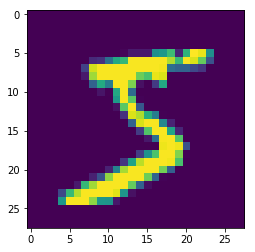

Label:  5


In [48]:
plt.imshow(X_train[0])    # show first number in the dataset
plt.show()
print('Label: ', y_train[0])

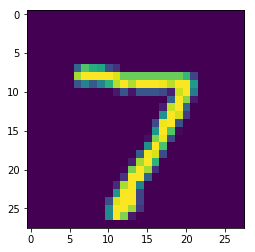

Label:  7


In [49]:
plt.imshow(X_test[0])    # show first number in the dataset
plt.show()
print('Label: ', y_test[0])

In [50]:
# reshaping X data: (n, 28, 28) => (n, 784)
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [51]:
# use only 33% of training data to expedite the training process
X_train, _ , y_train, _ = train_test_split(X_train, y_train, test_size = 0.67, random_state = 7)

In [52]:
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [53]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19800, 784) (10000, 784) (19800, 10) (10000, 10)


## Basic MLP model
- Naive MLP model without any alterations

In [54]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import optimizers

In [55]:
model = Sequential()

In [56]:
model.add(Dense(50, input_shape = (784, )))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [57]:
sgd = optimizers.SGD(lr = 0.001)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, validation_split = 0.3, epochs = 100, verbose = 0)

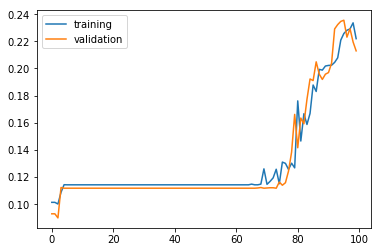

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

Training and validation accuracy seems to improve after around 60 epochs

In [15]:
results = model.evaluate(X_test, y_test)

 9376/10000 [===========================>..] - ETA: 0s

In [62]:
print('Test accuracy: ', results[1])

Test accuracy:  0.2144


## 1. Weight Initialization
- Changing weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree
- He normal or Xavier normal initialization schemes are SOTA at the moment
- Doc: https://keras.io/initializers/

In [10]:
# from now on, create a function to generate (return) models
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [11]:
model = mlp_model()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 0)

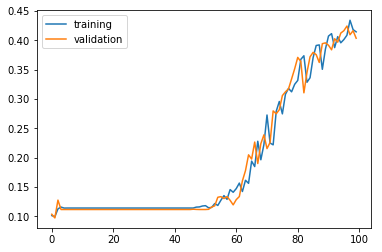

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

Training and validation accuracy seems to improve after around 60 epochs

In [15]:
results = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s     


In [16]:
print('Test accuracy: ', results[1])

Test accuracy:  0.4105


## 2. Nonlinearity (Activation function)
- Sigmoid functions suffer from gradient vanishing problem, making training slower
- There are many choices apart from sigmoid and tanh; try many of them!
    - **'relu'** (rectified linear unit) is one of the most popular ones
    - **'selu'** (scaled exponential linear unit) is one of the most recent ones
- Doc: https://keras.io/activations/

<img src="http://cs231n.github.io/assets/nn1/sigmoid.jpeg" style="width: 400px"/>
<center> **Sigmoid Activation Function** </center>
<img src="http://cs231n.github.io/assets/nn1/relu.jpeg" style="width: 400px"/>
<center> **Relu Activation Function** </center>

In [51]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, )))
    model.add(Activation('relu'))    # use relu
    model.add(Dense(50))
    model.add(Activation('relu'))    # use relu
    model.add(Dense(50))
    model.add(Activation('relu'))    # use relu
    model.add(Dense(50))
    model.add(Activation('relu'))    # use relu
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
model = mlp_model()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, verbose = 0)

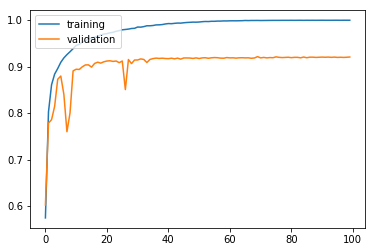

In [53]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

Training and validation accuracy improve instantaneously, but reach a plateau after around 30 epochs

In [54]:
results = model.evaluate(X_test, y_test)

 9376/10000 [===========================>..] - ETA: 0s

In [55]:
print('Test accuracy: ', results[1])

Test accuracy:  0.9208


## 3. Model Ensemble
- Model ensemble is a reliable and promising way to boost performance of the model
- Usually create 8 to 10 independent networks and merge their results
- Here, we resort to scikit-learn API, **VotingClassifier**
- Doc: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRs1CBSEtpp5yj6SJ5K_nHd1FNfyEYa9KLjWfoMY_v7ARTq3tdpVw" style="width: 300px"/>

In [12]:
import numpy as np

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [13]:
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [14]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (784, )))
    model.add(Activation('sigmoid'))    
    model.add(Dense(50))
    model.add(Activation('sigmoid'))    
    model.add(Dense(50))
    model.add(Activation('sigmoid'))    
    model.add(Dense(50))
    model.add(Activation('sigmoid'))    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [15]:
model1 = KerasClassifier(build_fn = mlp_model, epochs = 100, verbose = 0)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 100, verbose = 0)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 100, verbose = 0)

In [104]:
ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3)], voting = 'soft')

In [ ]:
ensemble_clf.fit(X_train, y_train)

In [106]:
y_pred = ensemble_clf.predict(X_test)

 9088/10000 [==========================>...] - ETA: 0s

In [109]:
print('Test accuracy:', accuracy_score(y_pred, y_test))

Test accuracy: 0.3045


Slight boost in the test accuracy from the outset **(0.2144 => 0.3045)**

## Summary

|Model           | Naive Model | He normal  | Relu        | Adam        | Batchnorm  | Dropout   | Ensemble   |
|----------------|-------------|------------|-------------|-------------|------------|-----------|------------|
|Test Accuracy   | 0.2144      | 0.4105     | 0.9208      | 0.9248      | 0.9154     | 0.1135    | 0.3045     |

<br>
It turns out that most methods improve the model training & test performance.
Why don't try them out altogether?